In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from accelerate import Accelerator

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, average_precision_score
from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import re

In [2]:
model = "roberta-large"

In [3]:
accelerator = Accelerator()

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model)

In [5]:
clf = AutoModelForSequenceClassification.from_pretrained(model, num_labels=2)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'clas

In [6]:
train_set = load_dataset("csv", data_files="/media/storage/datasets/disaster_tweets/train.csv", split='train[:90%]')
val_set = load_dataset("csv", data_files="/media/storage/datasets/disaster_tweets/train.csv", split='train[-10%:]')
test_set = load_dataset("csv", data_files="/media/storage/datasets/disaster_tweets/test.csv")

In [7]:
def clean(batch):
    clean_text = batch['text'].lower()
    clean_text = ' '.join(re.sub(r"https?:\/\/t.co\/.{10}",' ', clean_text).split())
    clean_text = ' '.join(re.sub(r"[^a-zA-Z '\.,-;:!?#]",' ', clean_text).split())
    return {"clean_text": clean_text}

In [8]:
train_set = train_set.map(clean, batched=False, batch_size=64)
val_set = val_set.map(clean, batched=False, batch_size=64)
test_set = test_set.map(clean, batched=False, batch_size=64)

In [9]:
def tokenize(batch):
    return tokenizer(batch["clean_text"], padding=True, truncation=True)

In [10]:
train_encoded = train_set.map(tokenize, batched=True, batch_size=64)
val_encoded = val_set.map(tokenize, batched=True, batch_size=64)
test_encoded = test_set.map(tokenize, batched=True, batch_size=64)

In [11]:
train_encoded = train_encoded.rename_column("target", "labels")
val_encoded = val_encoded.rename_column("target", "labels")

In [12]:
clf, train_encoded, val_encoded, test_encoded = accelerator.prepare(clf, train_encoded, val_encoded, test_encoded)

In [13]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [14]:
batch_size = 8
logging_steps = len(train_set) // batch_size
training_args = TrainingArguments(
                                    output_dir='nlp_model',
                                    num_train_epochs=10,
                                    learning_rate=1e-6,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    optim="adamw_torch",
                                    weight_decay=5e-7,
                                    lr_scheduler_type='cosine',
                                    evaluation_strategy="epoch",
                                    save_strategy="epoch",
                                    disable_tqdm=False,
                                    logging_steps=logging_steps,
                                    push_to_hub=False,
                                    log_level="error",
                                    seed=177013,
                                    load_best_model_at_end=True,
                                    metric_for_best_model='f1',
                                  )

In [15]:
trainer = Trainer(
                    model=clf,
                    args=training_args,
                    compute_metrics=compute_metrics,
                    train_dataset=train_encoded,
                    eval_dataset=val_encoded,
                    tokenizer=tokenizer
                 )

In [16]:
trainer.train();

wandb: Currently logged in as: dx2-66 (team_fairies). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.550800,0.354723,0.862024,0.842105
2,0.404700,0.382563,0.855453,0.842857
3,0.385900,0.387452,0.864652,0.845577
4,0.366800,0.467433,0.850197,0.838983
5,0.352600,0.482151,0.860710,0.846377
6,0.348300,0.465411,0.863338,0.849275
7,0.337500,0.528196,0.858081,0.844828
8,0.361200,0.518810,0.862024,0.848485
9,0.335600,0.548720,0.858081,0.844828
10,0.342300,0.552600,0.858081,0.844828


In [17]:
preds = trainer.predict(val_encoded)

In [18]:
target_test = val_encoded['labels']

In [19]:
def calculate_metrics(probs):
    predictions = probs > 0.5
    probabilities = probs
    f1 = f1_score(target_test, predictions)
    roc_auc = roc_auc_score(target_test, probabilities)
    acc = accuracy_score(target_test, predictions)
    ap = average_precision_score(target_test, probabilities)
    cmatrix = confusion_matrix(target_test, predictions)
    
    fpr, tpr, _ = roc_curve(target_test, probabilities)
    precision, recall, thresholds = precision_recall_curve(target_test, probabilities)
    f1_scores = 2*recall*precision/(recall+precision)
    best_f1 = np.max(f1_scores)
    best_thresh = thresholds[np.argmax (f1_scores)]

    pred_t = (probabilities > best_thresh)
    best_cmatrix = confusion_matrix(target_test, pred_t)
    
    return f1, best_f1, roc_auc, acc, ap, best_thresh, fpr, tpr, recall, precision, cmatrix, best_cmatrix

def visualize_tests(probs):
    cmatrices = []

    fig, axes = plt.subplots(1, 2, figsize=(15,6))
    axes[0].plot([0, 1], linestyle='--')
    axes[1].plot([0.5, 0.5], linestyle='--')

    name = type(clf).__name__
    print('Evaluating, please wait warmly...')
    f1, best_f1, roc_auc, acc, ap, best_thresh, fpr, tpr, recall, precision, cmatrix, best_cmatrix = calculate_metrics (probs)
    axes[0].plot (fpr, tpr);
    axes[1].plot (recall, precision);
    print (f'{name}: F1: {f1:.2f} (max: {best_f1:.2f} at {best_thresh:.2f} threshold), ROC_AUC: {roc_auc:.2f}, accuracy: {acc:.0%}, AP (PR_AUC): {ap:.2f}')
    cmatrices.append(cmatrix)
    cmatrices.append(best_cmatrix)
    
    axes[0].set (xlabel = 'FPR', ylabel = 'TPR', title = 'ROC curve', xlim=(0,1), ylim=(0,1))
    axes[1].set (xlabel = 'Recall', ylabel = 'Precision', title = 'PR curve', xlim=(0,1), ylim=(0,1))
    
    fig, axes = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)
    for cmatrix, ax, title in zip(cmatrices, axes.flat, ['Consusion matrix', 'Consusion matrix (optimal threshold)']):
        sns.heatmap(cmatrix, annot=True, cmap='Blues', fmt='d', ax=ax).set(title=title, xlabel='Prediction', ylabel='Reality')
    
    return best_thresh

Evaluating, please wait warmly...
RobertaForSequenceClassification: F1: 0.85 (max: 0.85 at 0.61 threshold), ROC_AUC: 0.91, accuracy: 86%, AP (PR_AUC): 0.92


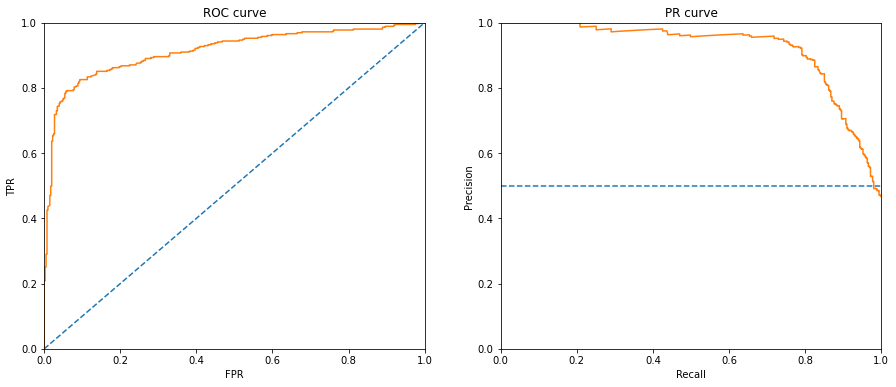

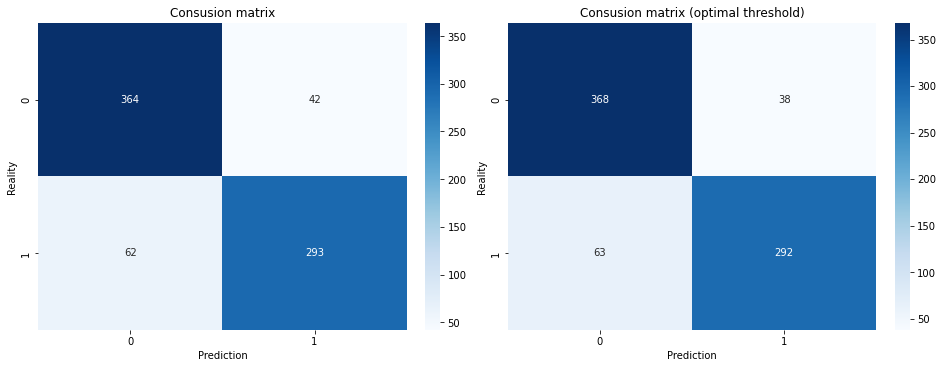

In [20]:
best_threshold = visualize_tests(softmax(preds.predictions, axis=1)[:,1])

In [21]:
preds = trainer.predict(test_encoded['train'])

In [22]:
score = softmax(preds.predictions, axis=1)[:,1]

In [23]:
result = pd.DataFrame({'id':test_set['train']['id'], 'target': (score > best_threshold).astype('int')})

In [24]:
result = result.set_index('id')

In [25]:
result.to_csv('sample_submission.csv')